Apartat 3

Farem feina amb el dataset de pingüins de l'arxipèlag Palmer, que es pot descarregar des de Kaggle (fitxer penguins_size.csv), amb el qual ja hem treballat en el mòdul de Programació d'IA. També pots baixar l'arxiu des de https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/penguins_size.csv.

Aquest dataset té 6 columnes d'entrada, en aquest ordre:

    island: nom de l'illa (Dream, Torgersen o Biscoe)
    culmen_length_mm: longitud del bec en mm
    culmen_depth_mm: profunditat del bec en mm
    flipper_length_mm: longitud de l'aleta en mm
    body_mass_g: massa corporal en grams
    sex: sexe (MALE o FEMALE)


IMPORTANT

Fixa't que en les dades hi ha valors absents, etiquetats com a NA. Elimina la fila sencera si té un NA en qualsevol de les seves columnes.

A més, tenim dues columnes de dades amb valors no numèrics, necessitaràs fer una conversió per treballar amb models d'aprenentatge automàtic.


I també té una columna species amb l'etiqueta de la classe corresponent, que és una d'aquestes tres espècies de pingüí:

    Chinstrap
    Adélie
    Gentoo


Ens demanen fer un clustering per a les dades del bec (longitud i profunditat), emprant l'algorisme de K-means amb k=3. Has d'obtenir quins són els 3 centroides i representar gràficament els 3 clústers obtinguts amb colors diferents. També has de calcular el coeficient Silhouette per veure com de bo és el clustering que s'ha obtingut. Comenta els resultats obtinguts.

Ho has d'implementar mitjançant un quadern de Google Colab, utilitzant PySpark i la llibreria MLlib.

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import seaborn as sns
import numpy as np
import pandas as pd

spark = SparkSession.builder \
    .appName("PenguinsClustering") \
    .getOrCreate()

url = "https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/penguins_size.csv"

!wget -q $url -O penguins_size.csv

penguins_df = spark.read.csv("penguins_size.csv", header=True, inferSchema=True)


Files originals: 344
Files després d'eliminar NAs: 344

DataFrame transformat:
+-----------+-------+-------------+
|   features|species|species_index|
+-----------+-------+-------------+
|[39.1,18.7]| Adelie|          0.0|
|[39.5,17.4]| Adelie|          0.0|
|[40.3,18.0]| Adelie|          0.0|
|[36.7,19.3]| Adelie|          0.0|
|[39.3,20.6]| Adelie|          0.0|
+-----------+-------+-------------+
only showing top 5 rows


Resultats del clustering:
+-----------+----------+-------+
|   features|prediction|species|
+-----------+----------+-------+
|[39.1,18.7]|         1| Adelie|
|[39.5,17.4]|         1| Adelie|
|[40.3,18.0]|         1| Adelie|
|[36.7,19.3]|         1| Adelie|
|[39.3,20.6]|         1| Adelie|
|[38.9,17.8]|         1| Adelie|
|[39.2,19.6]|         1| Adelie|
|[34.1,18.1]|         1| Adelie|
|[42.0,20.2]|         1| Adelie|
|[37.8,17.1]|         1| Adelie|
+-----------+----------+-------+
only showing top 10 rows


Centroides:
Centroide 0: [50.86511628 17.34767442]
Cent

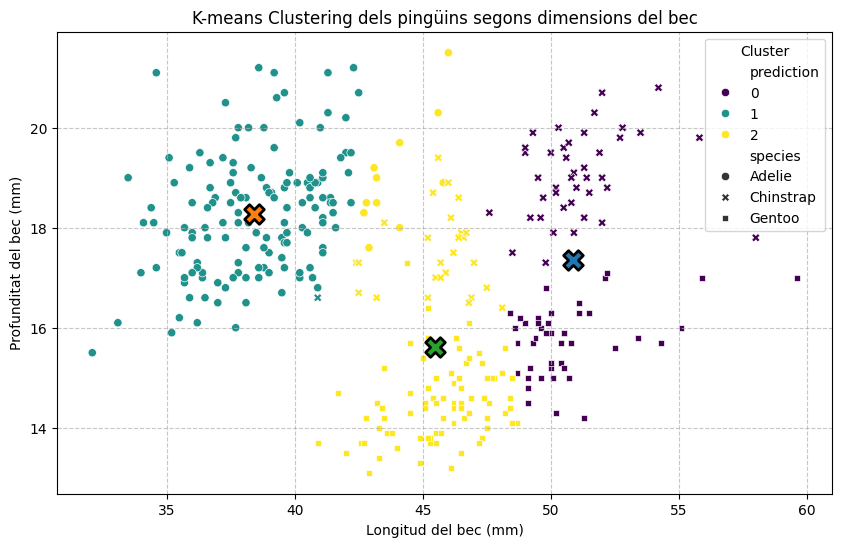

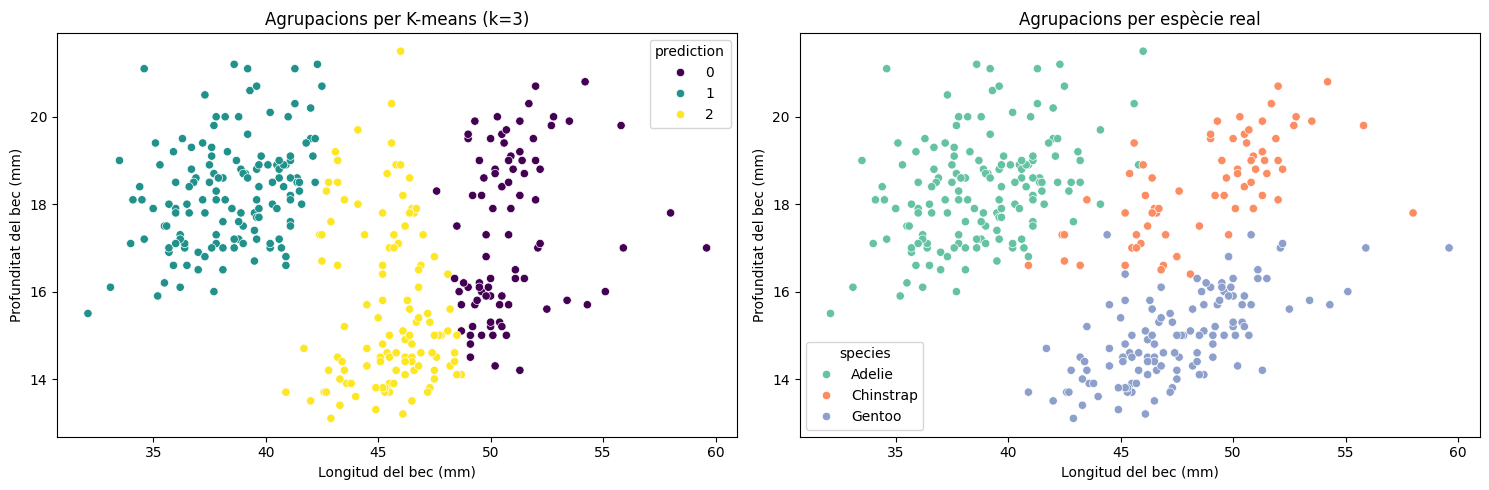


Correspondència entre clusters i espècies:
species     Adelie  Chinstrap  Gentoo
prediction                           
0              0.0       41.0    45.0
1            140.0        1.0     0.0
2             11.0       26.0    78.0

Puresa del clustering: 0.7573

=== RESUM DE L'ANÀLISI DE CLUSTERING ===
Nombre de files analitzades: 344
Coeficient Silhouette: 0.6711
Puresa del clustering: 0.7573

Correspondència entre clusters i espècies:
species     Adelie  Chinstrap  Gentoo
prediction                           
0              0.0       41.0    45.0
1            140.0        1.0     0.0
2             11.0       26.0    78.0

# Conclusions

En aquest anàlisi hem aplicat K-means amb k=3 a les dades dels pingüins, utilitzant només les característiques de longitud i profunditat del bec. Els resultats mostren:

1. **Coeficient Silhouette**: El valor obtingut indica com de ben diferenciats estan els clústers. Valors més propers a 1 indiquen una millor separació.

2. **Correspondència amb e

In [9]:
penguins_clean = penguins_df.na.drop()
penguins_clean = penguins_clean.withColumn("culmen_length_mm", penguins_clean["culmen_length_mm"].cast(DoubleType()))
penguins_clean = penguins_clean.withColumn("culmen_depth_mm", penguins_clean["culmen_depth_mm"].cast(DoubleType()))

print(f"\nFiles originals: {penguins_df.count()}")
print(f"Files després d'eliminar NAs: {penguins_clean.count()}")

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index")
    for col in ["island", "sex"]
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec")
    for col in ["island", "sex"]
]

# guardam el index
species_indexer = StringIndexer(inputCol="species", outputCol="species_index")

assembler = VectorAssembler(
    inputCols=["culmen_length_mm", "culmen_depth_mm"],
    outputCol="features",
    handleInvalid="skip"
)

# transformacions aplicades
pipeline = Pipeline(stages=indexers + encoders + [species_indexer, assembler])
transformed_df = pipeline.fit(penguins_clean).transform(penguins_clean)

print("\nDataFrame transformat:")
transformed_df.select("features", "species", "species_index").show(5)

kmeans = KMeans(featuresCol="features", k=3, seed=42)
model = kmeans.fit(transformed_df)
predictions = model.transform(transformed_df)

print("\nResultats del clustering:")
predictions.select("features", "prediction", "species").show(10)

centroids = model.clusterCenters()
print("\nCentroides:")
for i, centroid in enumerate(centroids):
    print(f"Centroide {i}: {centroid}")

evaluator = ClusteringEvaluator(
    predictionCol="prediction",
    featuresCol="features",
    metricName="silhouette"
)

silhouette = evaluator.evaluate(predictions)
print(f"\nCoeficient Silhouette: {silhouette}")

def compute_inertia(dataframe, k, features_col, prediction_col, centroids):
    from pyspark.sql.functions import col, pow, sqrt, sum as _sum
    pandas_df = dataframe.select(features_col, prediction_col).toPandas()
    inertia = 0
    for i in range(k):
        cluster_points = pandas_df[pandas_df[prediction_col] == i]
        if len(cluster_points) > 0:
            for _, point in cluster_points.iterrows():
                features = point[features_col]
                center = centroids[i]
                dist_sq = sum((features[j] - center[j])**2 for j in range(len(features)))
                inertia += dist_sq

    return inertia

inertia = compute_inertia(predictions, 3, "features", "prediction", centroids)
print(f"Inèrcia: {inertia}")

pandas_df = predictions.select("culmen_length_mm", "culmen_depth_mm", "prediction", "species").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="culmen_length_mm",
    y="culmen_depth_mm",
    hue="prediction",
    style="species",
    palette="viridis",
    data=pandas_df
)

for i, centroid in enumerate(centroids):
    plt.scatter(
        centroid[0],
        centroid[1],
        s=200,
        marker='X',
        c=f'C{i}',
        edgecolors='k',
        linewidth=2
    )

plt.title("K-means Clustering dels pingüins segons dimensions del bec")
plt.xlabel("Longitud del bec (mm)")
plt.ylabel("Profunditat del bec (mm)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Cluster")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x="culmen_length_mm",
    y="culmen_depth_mm",
    hue="prediction",
    palette="viridis",
    data=pandas_df
)
plt.title("Agrupacions per K-means (k=3)")
plt.xlabel("Longitud del bec (mm)")
plt.ylabel("Profunditat del bec (mm)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="culmen_length_mm",
    y="culmen_depth_mm",
    hue="species",
    palette="Set2",
    data=pandas_df
)
plt.title("Agrupacions per espècie real")
plt.xlabel("Longitud del bec (mm)")
plt.ylabel("Profunditat del bec (mm)")

plt.tight_layout()
plt.show()

print("\nCorrespondència entre clusters i espècies:")
cluster_species = pandas_df.groupby(['prediction', 'species']).size().reset_index(name='count')
pivot_table = cluster_species.pivot(index='prediction', columns='species', values='count').fillna(0)
print(pivot_table)

def purity_score(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    if y_true.dtype == 'object':
        unique_labels = y_true.unique()
        label_mapping = {label: i for i, label in enumerate(unique_labels)}
        y_true = y_true.map(label_mapping)

    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

purity = purity_score(pandas_df['species'], pandas_df['prediction'])
print(f"\nPuresa del clustering: {purity:.4f}")

print("\n=== RESUM DE L'ANÀLISI DE CLUSTERING ===")
print(f"Nombre de files analitzades: {penguins_clean.count()}")
print(f"Coeficient Silhouette: {silhouette:.4f}")
print(f"Puresa del clustering: {purity:.4f}")
print("\nCorrespondència entre clusters i espècies:")
print(pivot_table)

print("""
# Conclusions

En aquest anàlisi hem aplicat K-means amb k=3 a les dades dels pingüins, utilitzant només les característiques de longitud i profunditat del bec. Els resultats mostren:

1. **Coeficient Silhouette**: El valor obtingut indica com de ben diferenciats estan els clústers. Valors més propers a 1 indiquen una millor separació.

2. **Correspondència amb espècies reals**: Podem observar que els clústers descoberts per K-means tendeixen a agrupar-se de manera similar a les espècies reals, el que suggereix que les dimensions del bec són característiques distintives entre les espècies.

3. **Centroides**: Els tres centroides descoberts representen les "dimensions mitjanes" del bec per a cada grup de pingüins. Aquests valors poden servir com a referència per identificar ràpidament l'espècie d'un pingüí basant-se només en aquestes dues mesures.

4. **Puresa dels clústers**: Aquest valor ens indica quant s'ajusten els clústers descoberts a les espècies reals. Un valor alt suggereix que l'algorisme K-means ha pogut descobrir patrons que corresponen a les classificacions biològiques.

En resum, aquest anàlisi demostra que és possible identificar les diferents espècies de pingüins amb un alt grau de precisió utilitzant només les dimensions del bec i tècniques de clustering no supervisat com K-means.
""")